The goal of this exercise is to produce a convolutional neural network that can classify handwritten digits from 0-9 using the mnist dataset.

- Python 3.6.10 Anaconda
- Author: Jai Fadia (github.com/jai-fadia)

In [1]:
# import libraries
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

### Step 1: Load the dataset

In [2]:
# download the mnist dataset to the local drive
(train, test), info = tfds.load(
    name = 'mnist',
    split = ['train', 'test'],
    shuffle_files = True,
    as_supervised = True,
    with_info = True
)

### Step 2: Build the training pipeline

In [3]:
# create a function to normalize the images
def normalize(image, label):
    """
    Function to normalize the image and convert from uint8 --> float32

    Arguments:
    - image: image loaded from the dataset as uint8
    - label: classification label associated with each image as binary

    Returns a the normalized image as float32 and the label
    """

    return tf.cast(image, tf.float32) / 255, label

In [4]:
# apply the normalization function to all the images
train = train.map(normalize, num_parallel_calls = tf.data.experimental.AUTOTUNE)

# cache the dataset in memory to speed up retrieval
train = train.cache()

# shuffle the training set
train = train.shuffle(info.splits['train'].num_examples)

# set the batch size
train = train.batch(256)

# prefetch the data for better training performance
train = train.prefetch(tf.data.experimental.AUTOTUNE)

### Step 3: Build the evaluation pipeline

In [5]:
# apply the normalization function to all the images
test = test.map(normalize, num_parallel_calls = tf.data.experimental.AUTOTUNE)

# set the batch size
test = test.batch(256)

# cache the dataset in memory to speed up retrieval
test = test.cache()

# prefetch the data for better evaluation performance
test = test.prefetch(tf.data.experimental.AUTOTUNE)

### Step 4: Build and evaluate the model

In [6]:
# custom callback to stop training once validation accuracy >= 0.985
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, eopoch, logs = {}):
        if logs.get('val_accuracy') >= 0.985:
            print('\nAcheived >= 0.98 validation accuracy so stopping training.')
            self.model.stop_training = True

callback = myCallback()

In [7]:
# set up the convolutional neural network
# Conv2D --> MaxPool --> Flatten --> Dense --> Dense
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(input_shape = info.features['image'].shape, filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2, 2), padding = 'same'),
    tf.keras.layers.Flatten(input_shape = info.features['image'].shape),
    tf.keras.layers.Dense(units = 128, activation = 'relu'),
    tf.keras.layers.Dense(units = 10, activation = 'softmax')
])

In [8]:
# print out a summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1605760   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 1,607,690
Trainable params: 1,607,690
Non-trainable params: 0
_________________________________________________________________


In [9]:
# compile the model and use accuracy as the evaluation metric
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(0.001),
    metrics = ['accuracy']
)

In [10]:
# train the model using the PC's GPU
with tf.device('/gpu:0'):
    model.fit(
        train,
        epochs = 10,
        validation_data = test,
        callbacks = [callback]
    )

Epoch 1/10
235/235 [==============================] - 6s 27ms/step - loss: 0.2620 - accuracy: 0.9249 - val_loss: 0.1002 - val_accuracy: 0.9699
Epoch 2/10
235/235 [==============================] - 2s 10ms/step - loss: 0.0778 - accuracy: 0.9767 - val_loss: 0.0616 - val_accuracy: 0.9796
Epoch 3/10
235/235 [==============================] - 2s 10ms/step - loss: 0.0512 - accuracy: 0.9847 - val_loss: 0.0563 - val_accuracy: 0.9817
Epoch 4/10
235/235 [==============================] - 2s 10ms/step - loss: 0.0381 - accuracy: 0.9884 - val_loss: 0.0571 - val_accuracy: 0.9813
Epoch 5/10
235/235 [==============================] - 2s 10ms/step - loss: 0.0297 - accuracy: 0.9911 - val_loss: 0.0428 - val_accuracy: 0.9842
Epoch 6/10
231/235 [============================>.] - ETA: 0s - loss: 0.0235 - accuracy: 0.9929
Acheived >= 0.98 validation accuracy so stopping training.
235/235 [==============================] - 2s 10ms/step - loss: 0.0234 - accuracy: 0.9930 - val_loss: 0.0429 - val_accuracy: 0.985

### Step 5: Visualize performance

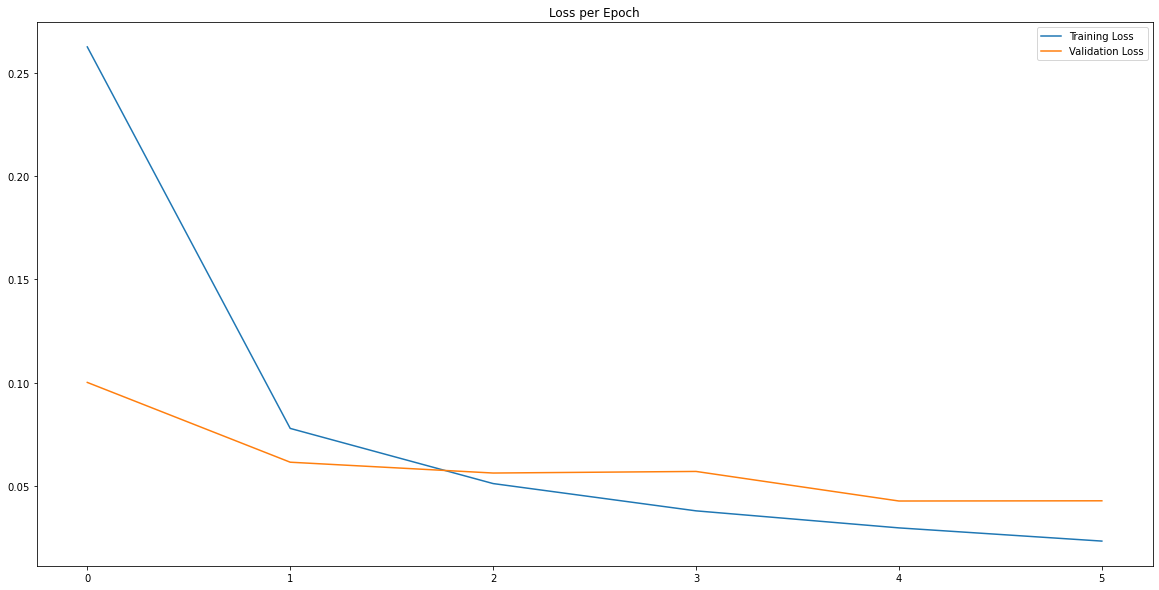

In [11]:
# plot the training and validation losses per epoch
plt.figure(figsize = (20, 10))
plt.plot(model.history.history.get('loss'))
plt.plot(model.history.history.get('val_loss'))
plt.title('Loss per Epoch')
plt.legend(labels = ['Training Loss', 'Validation Loss'])

Notes:
- Both the training and validation losses fell significantly during the second epoch and are very close by the 4th epoch
- Satisfied with the result

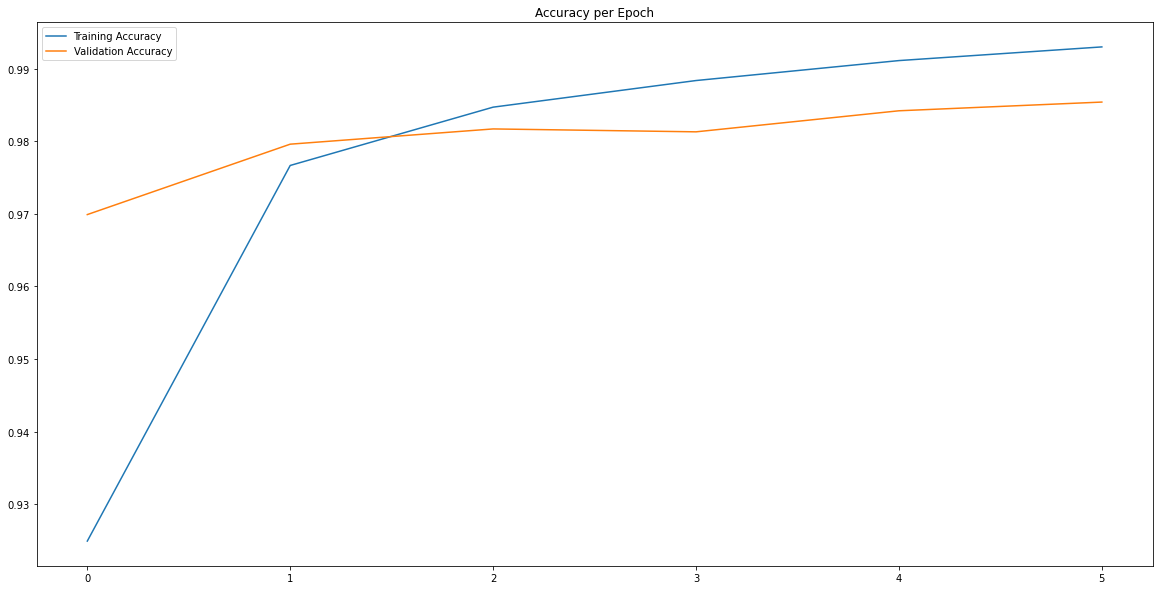

In [12]:
# plot the training and validation accuracy per epoch
plt.figure(figsize = (20, 10))
plt.plot(model.history.history.get('accuracy'))
plt.plot(model.history.history.get('val_accuracy'))
plt.title('Accuracy per Epoch')
plt.legend(labels = ['Training Accuracy', 'Validation Accuracy'])

Notes:
- The training and validation accuracy are both close and above the threshold of 0.985
- The model has not overfit or underfit because it is able to predict with a high degree of accuracy on both the training and validation sets

### End